In [4]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum
from ase.optimize import LBFGS, BFGS
from ase import Atom

from ase.io.trajectory import Trajectory
from ase.md import Langevin, Bussi
from ase import io

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


#macemp = mace_mp(dispersion=True, default_dtype="float64")
macemp_omat = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=True, default_dtype="float64")


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


In [5]:
import importlib
import interlayer_spacing
importlib.reload(interlayer_spacing)

from interlayer_spacing import calculate_interlayer_spacing, set_interlayer_spacing

In [141]:
# exclude pre-equilibration
mg_na_traj = io.read("trajectories/mg_na_omat_25000.traj", index="100:")
mgo_na_traj = io.read("trajectories/mgo_na_omat_25000.traj", index="100:")
mgoh_na_traj = io.read("trajectories/mgoh_na_omat_25000.traj", index="100:")

In [415]:
mg_na_traj_flip = io.read("trajectories/mg_na_omat_flipped_25000.traj", index=":")
mgo_na_traj_flip = io.read("trajectories/mgo_na_omat_flipped_25000.traj", index=":")
mgoh_na_traj_flip = io.read("trajectories/mgoh_na_omat_flipped_25000.traj", index=":")

In [486]:
mg_na_many_traj = io.read("trajectories/mg_na_many_omat_25000.traj", index=":")
mgo_na_many_traj = io.read("trajectories/mgo_na_many_omat_25000.traj", index=":")
mgoh_na_many_traj = io.read("trajectories/mgoh_na_many_omat_25000.traj", index=":")

### Heatmap of interlayer spacing
- LHS figure 6: image of last frame strucutre in the paper
- divide the xy plane of the lattice into 8x8 grids

In [16]:
na_indices = [atom.index for atom in mg_na_traj[0] if atom.symbol == 'Na']

calculate_interlayer_spacing(mg_na_traj[0])

4.083286694249999

In [44]:
mg_na_traj[0]

Atoms(symbols='C66NaO32Ti32', pbc=[True, True, False], cell=[[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]], momenta=..., tags=..., constraint=[<ase.constraints.FixSubsetCom object at 0x325598b30>, <ase.constraints.FixSubsetCom object at 0x334d56930>], calculator=SinglePointCalculator(...))

In [20]:
mg_na_traj[0].cell

Cell([[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]])

In [ ]:
def interlayer_spacing_section(atoms):
    mxene_atoms = [atom for atom in atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na']
    graphene_atoms = [atom for atom in atoms if atom.tag == 10]
    graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])

    top_O = [atom for atom in mxene_atoms if atom.tag == 3]
    mxene_z = np.mean([atom.position[2] for atom in top_O]) if top_O else max(atom.position[2] for atom in mxene_atoms)

    return graphene_avg_z - mxene_z

In [28]:
from ase.geometry import find_mic

grid_size = 8


cell = mg_na_traj[0].cell
# create a hexagonal grid
inv_cell = np.linalg.inv(cell[:2, :2].T)  # Inverse of the 2D cell basis (XY-plane)

# Define the 8×8 hexagonal grid in fractional coordinates
num_bins = 8
grid_frac_x = np.linspace(0, 1, num_bins + 1)  # Fractional coords along a1
grid_frac_y = np.linspace(0, 1, num_bins + 1)  # Fractional coords along a2
X_frac, Y_frac = np.meshgrid(grid_frac_x[:-1], grid_frac_y[:-1])  # Grid center positions

interlayer_spacing = np.zeros((num_bins, num_bins, len(mg_na_traj)))

In [52]:
cell

Cell([[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]])

In [58]:
cell[0]

array([12.12,  0.  ,  0.  ])

In [111]:
def interlayer_spacing_section(atoms, section_center, section_size):
    """Compute interlayer spacing for atoms within a given section."""
    x_min, x_max = section_center[0] - section_size / 2, section_center[0] + section_size / 2
    y_min, y_max = section_center[1] - section_size / 2, section_center[1] + section_size / 2

    section_atoms = [atom for atom in atoms if x_min <= atom.position[0] <= x_max and y_min <= atom.position[1] <= y_max]

    mxene_atoms = [atom for atom in section_atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na']
    graphene_atoms = [atom for atom in section_atoms if atom.tag == 10]

    if not mxene_atoms or not graphene_atoms:
        print("No atoms in section")
        return np.nan  # Skip empty sections

    graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])

    
    top_O = [atom for atom in mxene_atoms if atom.tag == 3]
    if top_O:
        #print("top O in section")
        mxene_z = np.mean([atom.position[2] for atom in top_O])
        print("mxene z: ", mxene_z)
    else:
        mxene_z = np.max([atom.position[2] for atom in mxene_atoms])
        print("mxene z no O: ", mxene_z)
    #mxene_z = np.mean([atom.position[2] for atom in top_O]) if top_O else (max(atom.position[2] for atom in mxene_atoms) and print("no O"))

    return graphene_avg_z - mxene_z

In [39]:
def interlayer_spacing_section(atoms, section_center, section_size):
    """Compute interlayer spacing for atoms within a given section defined by corners."""
    x_min, x_max = section_center[0] - section_size / 2, section_center[0] + section_size / 2
    y_min, y_max = section_center[1] - section_size / 2, section_center[1] + section_size / 2

    

    # Select atoms in this section
    section_atoms = [atom for atom in atoms if x_min <= atom.position[0] <= x_max and y_min <= atom.position[1] <= y_max]

    if not section_atoms:
        graphene_avg_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 10])  # Global graphene avg
        mxene_z = max(atom.position[2] for atom in atoms if atom.tag == 3 and atom.symbol != 'Na')  # Global MXene max
        return graphene_avg_z - mxene_z

    # Separate atoms into graphene and MXene
    graphene_atoms = [atom for atom in section_atoms if atom.tag == 10]
    mxene_atoms = [atom for atom in section_atoms if atom.tag == 3 and atom.symbol != 'Na']
    top_O = [atom for atom in mxene_atoms if atom.tag == 3]  # O atoms

    # Compute graphene height
    if graphene_atoms:
        graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])
    else:
        graphene_avg_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 10]) # Global graphene avg

    # Compute MXene height
    if top_O:
        mxene_z = np.mean([atom.position[2] for atom in top_O])
    else:
        #mxene_z = max(atom.position[2] for atom in mxene_atoms) if mxene_atoms else np.mean([atom.position[2] for atom in atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])
        mxene_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 3 and atom.symbol != 'Na'])
    return graphene_avg_z - mxene_z


In [146]:
np.mean([atom.position[2] for atom in mg_na_traj[500] if atom.tag == 3 and atom.symbol != 'Na'])

12.390918768212867

In [145]:
np.mean([atom.position[2] for atom in mgo_na_traj[500] if atom.tag == 10])  # Global graphene avg

16.534222264559904

In [160]:
na_pos = [atom.position[:2] for atom in mg_na_traj[0] if atom.symbol == 'Na'][0]
na_pos

array([3.04901013, 5.21016283])

- choose no. frames to avg over

In [100]:
import matplotlib.ticker as ticker


mg_na_traj = io.read("trajectories/mg_na_omat_flipped_25000.traj", index=":")

mgo_na_traj_norelax_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_25000.traj", index=":")
mgoh_na_traj_norelax_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_25000.traj", index=":")

def interlayer_heatmap(traj, gridsize, n_frames, plot_na=True, filepath=None):

    # Extract cell parameters (parallelogram)
    cell = traj[0].cell
    a1, a2 = cell[0][:2], cell[1][:2]  # Only x and y components for 2D representation

    # Define grid resolution (Grid **corners**, not centers)
    num_x, num_y = gridsize, gridsize

    # Generate grid points as corners
    x_vals = np.linspace(0, 1, num_x)
    y_vals = np.linspace(0, 1, num_y)
    grid_corners = np.array([x * a1 + y * a2 for x in x_vals for y in y_vals])

    # Initialize array to store interlayer spacing for each grid section
    interlayer_spacing_values = np.zeros(len(grid_corners))

    # Define section size based on grid resolution
    section_size = np.linalg.norm(a1) / (num_x - 1)  # Adjusted for corner grid

    frames = traj[:n_frames]

    # Compute interlayer spacing per grid **corner** and average over frames
    for frame in frames:  # Use first 10 frames
        spacing_grid = np.array([interlayer_spacing_section(frame, corner, section_size) for corner in grid_corners])
        interlayer_spacing_values += np.nan_to_num(spacing_grid)  # Replace NaN with zero for summation

    interlayer_spacing_values /= len(frames)  # Average over frames

    # Define parallelogram shape
    parallelogram = np.array([
        np.array([0, 0]),   # Origin
        a1,                 # First vector
        a1 + a2,            # First + Second vector
        a2,                 # Second vector
        np.array([0, 0])    # Close the loop
    ])

    # Plot heatmap inside parallelogram
    plt.figure(figsize=(6, 6))

    from scipy.ndimage import gaussian_filter
    smooth_interlayer_spacing = gaussian_filter(interlayer_spacing_values, sigma=0.5)
    #smooth_interlayer_spacing = interlayer_spacing_values
    contour = plt.tricontourf(grid_corners[:, 0], grid_corners[:, 1], smooth_interlayer_spacing, levels=100, cmap="Blues")

    # Overlay parallelogram boundary
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1.5)

    # Formatting
    plt.axis("equal")
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")  # Remove axes

    # Colorbar with fixed formatting (3 decimal places)
    cbar = plt.colorbar(contour, label="Distance (Å)", shrink=0.5)
    vmin, vmax = contour.get_clim()
    cbar.set_ticks(np.linspace(vmin, vmax, 5))
    cbar.formatter = ticker.FormatStrFormatter("%.2f")
    cbar.update_ticks()

    # Plot grid **corners** (was grid centers before)
    #plt.scatter(grid_corners[:, 0], grid_corners[:, 1], color='red', zorder=3, label="Grid Corners", alpha=0.5)

    na_pos = [atom.position[:2] for atom in traj[-1] if atom.symbol == 'Na'][0]
    if plot_na:
        plt.scatter(na_pos[0], na_pos[1], color='darkviolet', zorder=3, label="Na", s=300, edgecolors='k')

    # plot O atom with tag 11 if present
    graphene_O = [atom.position[:2] for atom in traj[-1] if atom.tag == 11]
    if graphene_O:
        plt.scatter(graphene_O[0][0], graphene_O[0][1], color='red', zorder=3, label="O", s=150, edgecolors='k')
    graphene_H = [atom.position[:2] for atom in traj[-1] if atom.tag == 12]
    if graphene_H:
        plt.scatter(graphene_H[0][0], graphene_H[0][1], color='white', zorder=3, label="H", s=100, edgecolors='k')

    plt.legend()
    
    if filepath:
        plt.savefig(f"figures/{filepath}", dpi=500)
    plt.show()


In [37]:
mg_na_traj_norelax100000_500 = io.read("trajectories/mg_na_omat_flipped_norelax_100000.traj", index="500:")
mgo_na_traj_norelax100000_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_100000.traj", index="500:")
mgoh_na_traj_norelax100000_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_100000.traj", index="500:")

mg_na_traj_norelax100000_2000 = io.read("trajectories/mg_na_omat_flipped_norelax_100000.traj", index="2000:")
mgo_na_traj_norelax100000_2000 = io.read("trajectories/mgo_na_omat_flipped_norelax_100000.traj", index="2000:")
mgoh_na_traj_norelax100000_2000 = io.read("trajectories/mgoh_na_omat_flipped_norelax_100000.traj", index="2000:")

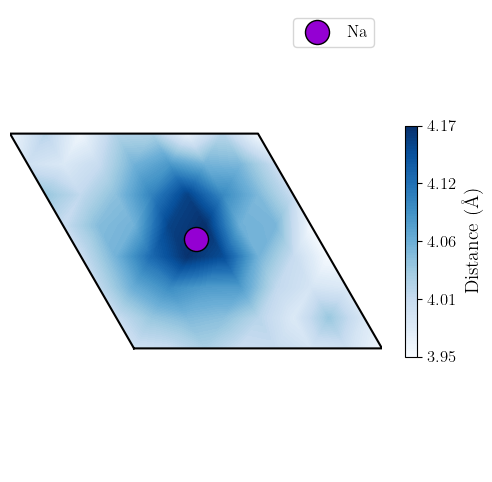

In [101]:
interlayer_heatmap(mg_na_traj_norelax100000_2000, 8, n_frames=1000, filepath="heatmap_mg_na.png") 

In [68]:
len(mgo_na_traj_norelax100000_2000)

8001

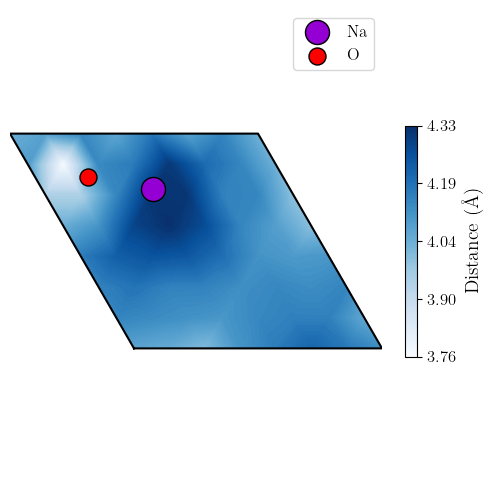

In [103]:
interlayer_heatmap(mgo_na_traj_norelax100000_2000, 8, n_frames=8000, filepath="heatmap_mgo_na_8000.png")

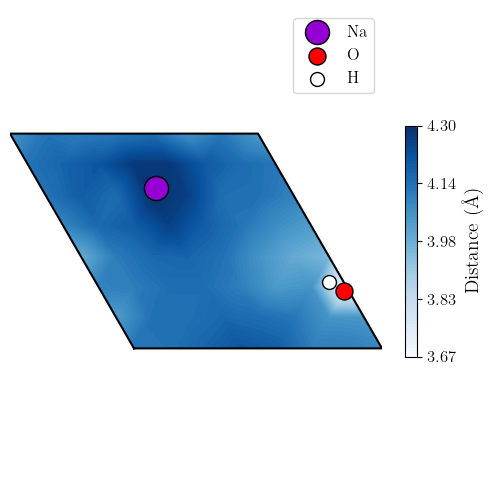

In [102]:
interlayer_heatmap(mgoh_na_traj_norelax100000_2000, 8, n_frames=1000, filepath="heatmap_mgoh_na.png")

### Heatmap of multiple Na ions

In [ ]:
mg_na_many_flip_norelax_traj_500 = io.read("trajectories/mg_na_many_omat_flip_norelax_25000.traj", index="500:")
mgo_na_many_flip_norelax_traj_500 = io.read("trajectories/mgo_na_many_omat_flip_norelax_25000.traj", index="500:")
mgoh_na_many_flip_norelax_traj_500 = io.read("trajectories/mgoh_na_many_omat_flip_norelax_25000.traj", index="500:")


In [71]:
mg_na_many_flip_norelax_traj_2000_100000 = io.read("trajectories/mg_na_many_omat_flipped_norelax_100000.traj", index="2000:")
mgo_na_many_flip_norelax_traj_2000_100000 = io.read("trajectories/mgo_na_many_omat_flipped_norelax_100000.traj", index="2000:")
mgoh_na_many_flip_norelax_traj_2000_100000 = io.read("trajectories/mgoh_na_many_omat_flipped_norelax_100000.traj", index="2000:")

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_81212/2831759467.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


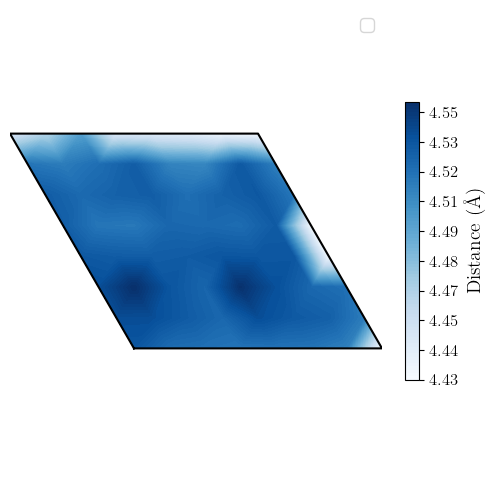

In [75]:
interlayer_heatmap(mg_na_many_flip_norelax_traj_2000_100000, 8, n_frames=8000, plot_na=False)

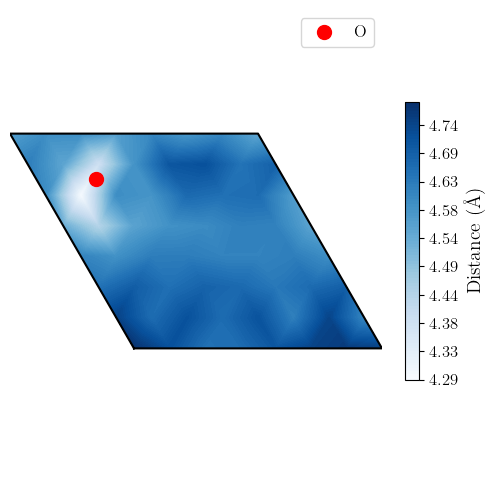

In [76]:
interlayer_heatmap(mgo_na_many_flip_norelax_traj_2000_100000, 8, n_frames=8000, plot_na=False)

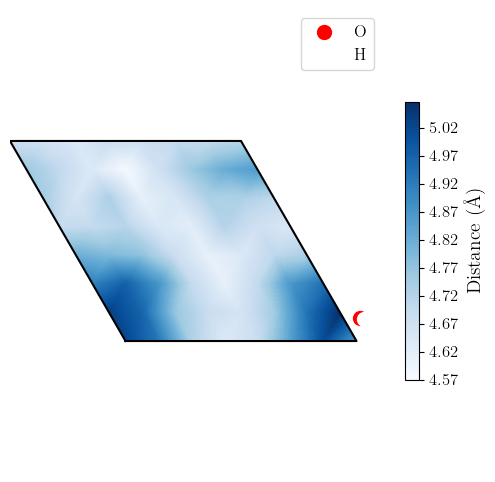

In [77]:
interlayer_heatmap(mgoh_na_many_flip_norelax_traj_2000_100000, 8, n_frames=8000, plot_na=False)

### MSD of a single Na ion

- non-linear MSD: hindrance to sodium ion diffusion -> bad

$$MSD(\tau) = \langle |r(t+\tau) - r(t)|^2 \rangle$$
- need an ensembl avg
- treat each time step as a new starting point
- use a sliding window avg


In [176]:
mg_na_traj[0][-1]

Atom('Na', [3.049010126707053, 5.210162831657062, 13.880788314391625], tag=0, momentum=[-0.5375451442731526, -0.7919408667589315, -0.5159708706629739], index=-1)

In [636]:
len(mgo_na_traj_norelax_500)

60

In [648]:
#mgo_na_traj_norelax_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_25000.traj", index=":")
mgoh_na_traj_norelax_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_25000.traj", index=":")

### Sliding window

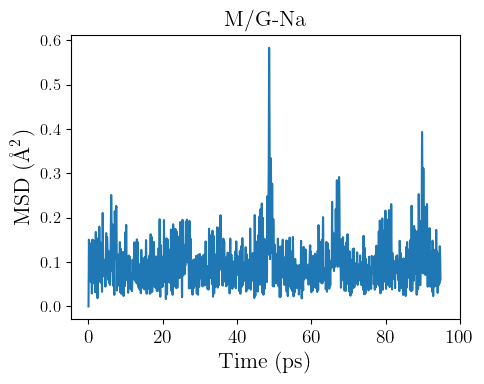

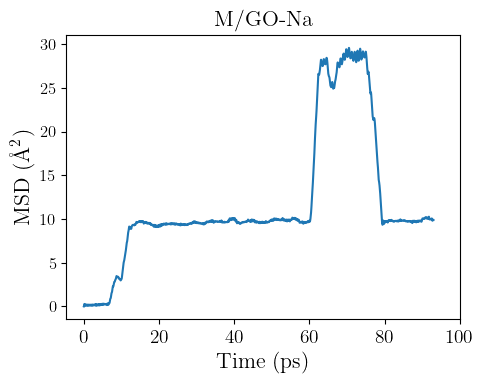

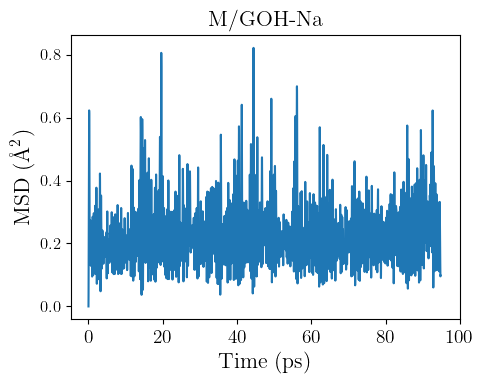

In [35]:
import numpy as np
from ase.io import Trajectory
import matplotlib.pyplot as plt

# mg_na_traj_500 = io.read("trajectories/mg_na_omat_25000.traj", index="500:")
# mgo_na_traj_500 = io.read("trajectories/mgo_na_omat_25000.traj", index=":")
# mgoh_na_traj_500 = io.read("trajectories/mgoh_na_omat_25000.traj", index=":")

mg_na_traj_500 = io.read("trajectories/mg_na_omat_flipped_25000.traj", index="500:")
mgo_na_traj_500 = io.read("trajectories/mgo_na_omat_flipped_25000.traj", index="500:")
mgoh_na_traj_500 = io.read("trajectories/mgoh_na_omat_flipped_25000.traj", index="500:")

mgo_na_traj_norelax_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_25000.traj", index="500:")
mgoh_na_traj_norelax_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_25000.traj", index=":")

mg_na_traj_norelax50000_500 = io.read("trajectories/mg_na_omat_flipped_norelax_50000.traj", index="500:")
mgo_na_traj_norelax50000_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_50000.traj", index="500:")
mgoh_na_traj_norelax50000_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_50000.traj", index="500:")

mg_na_traj_norelax100000_500 = io.read("trajectories/mg_na_omat_flipped_norelax_100000.traj", index="500:")
mgo_na_traj_norelax100000_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_100000.traj", index="500:")
mgoh_na_traj_norelax100000_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_100000.traj", index="500:")


data = [mg_na_traj_norelax100000_500, mgo_na_traj_norelax100000_500, mgoh_na_traj_norelax100000_500]

labels = ["MG-Na", "MGO-Na", "MGOH-Na"]
titles = ["M/G-Na", "M/GO-Na", "M/GOH-Na"]

#fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (traj, label, title) in enumerate(zip(data, labels, titles)):
    # Identify the sodium ion
    sodium_indices = [idx for idx, atom in enumerate(traj[0]) if atom.symbol == 'Na']
    sodium_index = sodium_indices[0]

    # Extract positions of the sodium ion
    positions = np.array([atoms[sodium_index].position for atoms in traj])

    n_frames = len(positions)
    if label == "MGO-Na":
        window_size = 200
    else:
        window_size = 20
    max_tau = n_frames - window_size

    msd = np.zeros(max_tau)

    for tau in range(1, max_tau):
        displacements = positions[tau:tau+window_size] - positions[:window_size]
        squared_displacements = np.sum(displacements**2, axis=1)
        msd[tau] = np.mean(squared_displacements)  # moving average over window

    # Time axis
    time_step = 1  # Adjust based on your timestep
    time_axis = np.arange(len(msd)) * time_step / 100  # Convert to ps

    # Plot MSD in subplot
    # axes[i].plot(time_axis, msd, label=f"MSD ({label})")
    # axes[i].set_xlabel("Time (ps)")
    # axes[i].set_ylabel(r"MSD ($\mathrm{\AA^2}$)")
    # axes[i].set_title(f"MSD of Na in {label}")
    # axes[i].set_xticks([0, 20, 40, 60, 80, 100])
    
    plt.figure(figsize=(5, 4))
    plt.plot(time_axis, msd, label=f"MSD ({label})")
    plt.xlabel("Time (ps)", fontsize=16)
    plt.ylabel(r"MSD ($\mathrm{\AA^2}$)", fontsize=16)
    plt.title(f"{title}")
    plt.xticks([0, 20, 40, 60, 80, 100], fontsize=14)
    plt.tight_layout()
    plt.savefig(f"figures/MSD_{label}.png", dpi=500)
    plt.show()
    
# Adjust layout
# plt.tight_layout()
# plt.show()

In [903]:
time_axis

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.298e+01, 9.299e+01,
       9.300e+01])

### Ensemble avg

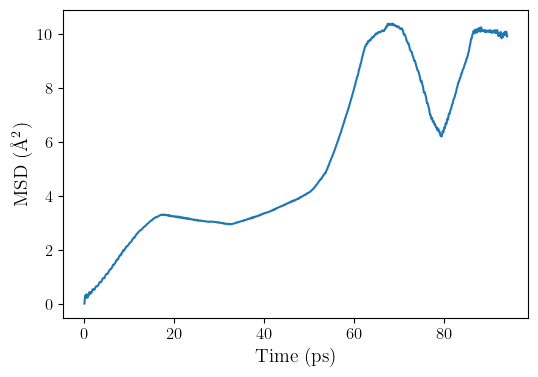

In [897]:


traj = mgo_na_traj_norelax100000_500

# Identify the sodium ion
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']

sodium_index = sodium_indices[0]

positions = np.array([atoms[sodium_index].position for atoms in traj])

n_frames = len(positions)
window_size = 100
max_tau = n_frames - window_size

msd = np.zeros(max_tau)


for tau in range(1, max_tau):
    displacements = positions[tau:] - positions[:-tau]
    squared_displacements = np.sum(displacements**2, axis=1)
    msd[tau] = np.mean(squared_displacements)

time_step = 1
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Plot MSD
plt.figure(figsize=(6, 4))
plt.plot(time_axis, msd[1:])
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD ($\mathrm{\AA^2}$)")
plt.show()
        

### MSD wrt starting positon

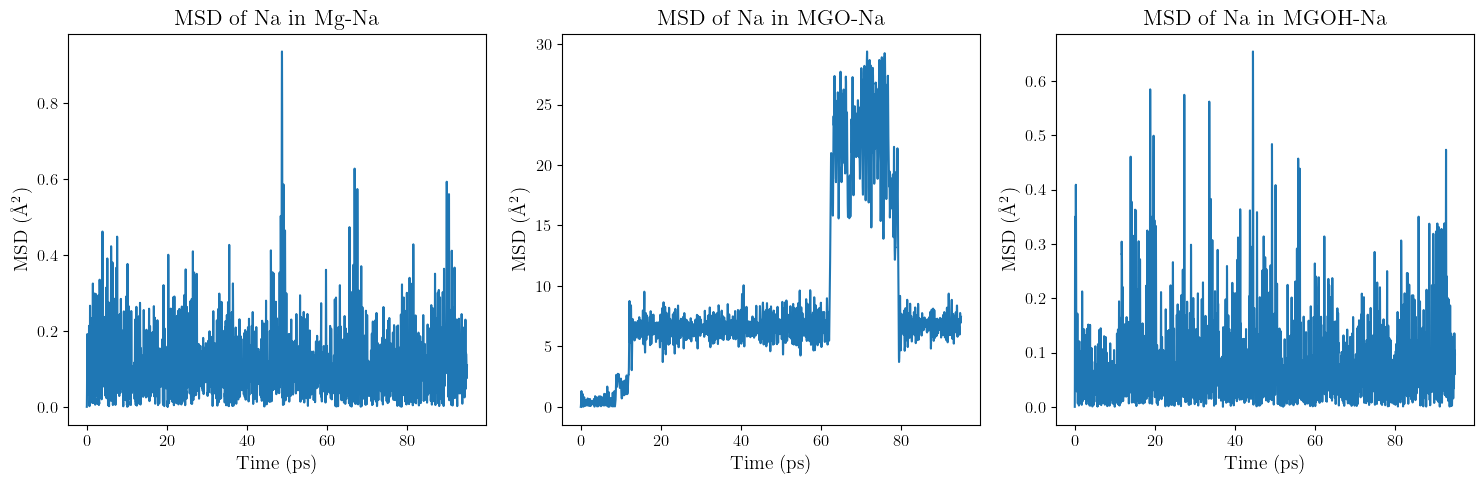

In [899]:
import numpy as np
import matplotlib.pyplot as plt

mgo_na_traj_norelax_500 = io.read("trajectories/mgo_na_omat_flipped_norelax_25000.traj", index=":-500")
mgoh_na_traj_norelax_500 = io.read("trajectories/mgoh_na_omat_flipped_norelax_25000.traj", index="500:")

#data = [mg_na_traj_500, mgo_na_traj_norelax_500, mgoh_na_traj_norelax_500]
data = [mg_na_traj_norelax100000_500, mgo_na_traj_norelax100000_500, mgoh_na_traj_norelax100000_500]

labels = ["Mg-Na", "MGO-Na", "MGOH-Na"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (traj, label) in enumerate(zip(data, labels)):
    # Identify the sodium ion
    sodium_indices = [idx for idx, atom in enumerate(traj[0]) if atom.symbol == 'Na']
    sodium_index = sodium_indices[0]

    # Extract positions of the sodium ion
    positions = np.array([atoms[sodium_index].position for atoms in traj])

    # Compute MSD with respect to the starting position
    initial_position = positions[0]  # Reference position at t=0
    displacements = positions - initial_position  # Displacement from initial position
    msd = np.sum(displacements**2, axis=1)  # Squared displacement

    # Time axis
    time_step = 1  # Adjust based on your timestep
    time_axis = np.arange(len(msd)) * time_step / 100  # Convert to ps

    # Plot MSD in subplot
    axes[i].plot(time_axis, msd, label=f"MSD ({label})")
    axes[i].set_xlabel("Time (ps)")
    axes[i].set_ylabel(r"MSD ($\mathrm{\AA^2}$)")
    axes[i].set_title(f"MSD of Na in {label}")
    
# Adjust layout
plt.tight_layout()
plt.show()


### MSD of the most mobile sodium ion from 1/2 ML coverage

In [783]:
mg_na_many_traj_500 = io.read("trajectories/mg_na_many_omat_25000.traj", index="500:")
mgo_na_many_traj_500 = io.read("trajectories/mgo_na_many_omat_25000.traj", index="500:")
mgoh_na_many_traj_500 = io.read("trajectories/mgoh_na_many_omat_25000.traj", index="500:")

mg_na_many_flip_norelax_traj_500 = io.read("trajectories/mg_na_many_omat_flip_norelax_25000.traj", index="500:")
mgo_na_many_flip_norelax_traj_500 = io.read("trajectories/mgo_na_many_omat_flip_norelax_25000.traj", index="500:")
mgoh_na_many_flip_norelax_traj_500 = io.read("trajectories/mgoh_na_many_omat_flip_norelax_25000.traj", index="500:")


In [904]:
mg_na_many_flip_norelax_traj_500_100000 = io.read("trajectories/mg_na_many_omat_flipped_norelax_100000.traj", index="500:")
mgo_na_many_flip_norelax_traj_500_100000 = io.read("trajectories/mgo_na_many_omat_flipped_norelax_100000.traj", index="500:")
mgoh_na_many_flip_norelax_traj_500_100000 = io.read("trajectories/mgoh_na_many_omat_flipped_norelax_100000.traj", index="500:")

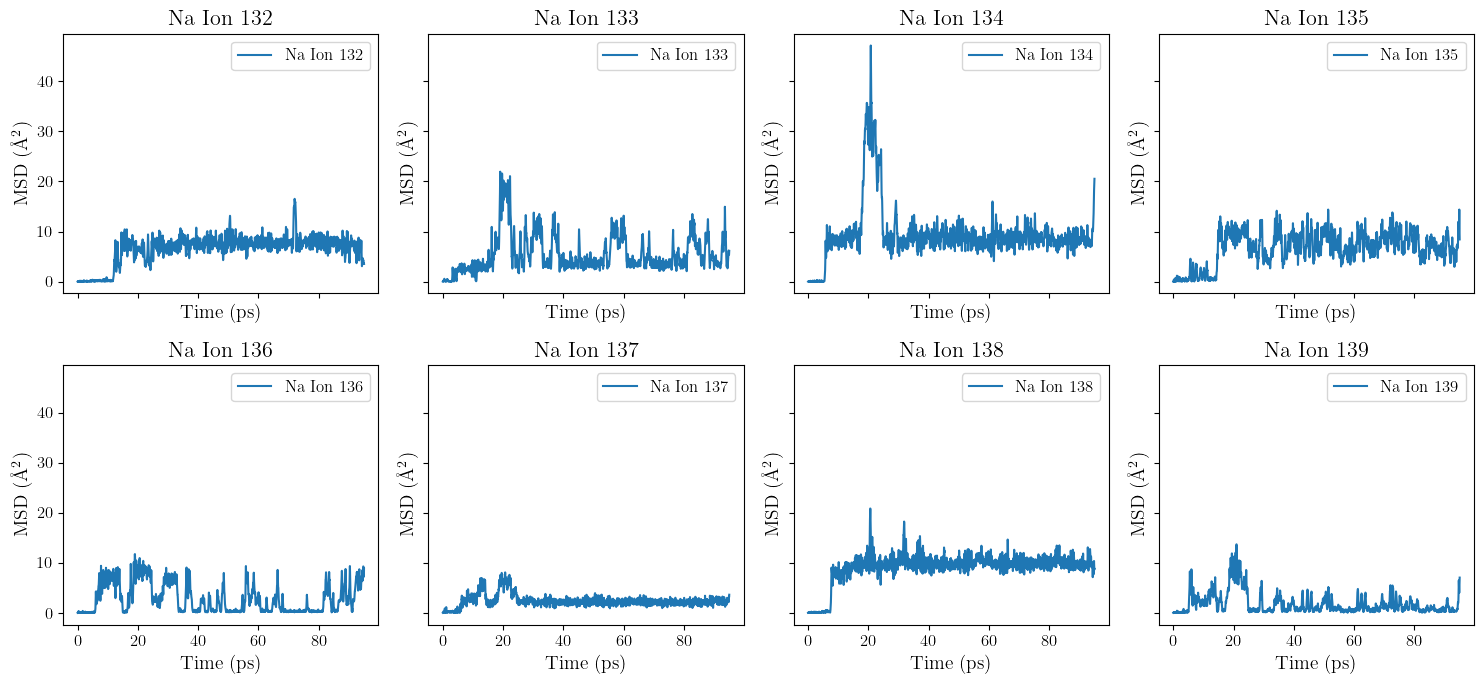

In [907]:
import numpy as np
import matplotlib.pyplot as plt

# Select the trajectory
traj = mgoh_na_many_flip_norelax_traj_500_100000  

# Get sodium indices
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']
num_na = len(sodium_indices)

# Prepare MSD calculations
n_frames = len(traj)

# Set up subplots: 2 rows × 4 columns
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easy iteration

time_step = 1  # Adjust based on your trajectory timestep
time_axis = np.arange(n_frames) * time_step / 100  # Convert to ps

# Loop over all Na ions
for i, na_index in enumerate(sodium_indices):
    positions = np.array([atoms[na_index].position for atoms in traj])  # Get positions for this Na ion
    
    # Compute MSD using the initial position as reference
    initial_position = positions[0]  # Fixed starting point
    displacements = positions - initial_position  # Displacement from start
    msd = np.sum(displacements**2, axis=1)  # Squared displacement

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(time_axis, msd, label=f"Na Ion {na_index}")
    ax.set_title(f"Na Ion {na_index}")
    ax.set_xlabel("Time (ps)")
    ax.set_ylabel(r"MSD ($\mathrm{\AA^2}$)")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


8


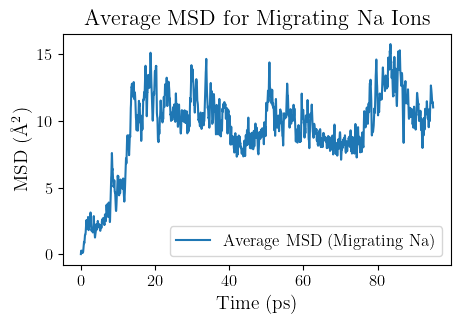

In [910]:
import numpy as np
import matplotlib.pyplot as plt

# Select the trajectory (after frame 500)
traj = mg_na_many_flip_norelax_traj_500_100000

# Get sodium indices
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']
num_na = len(sodium_indices)

# Prepare MSD calculations
n_frames = len(traj)
max_tau = n_frames - 1

time_step = 1  # Adjust based on your trajectory timestep
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Store MSD values for migrating Na ions
msd_list = []

# Loop over all Na ions
for na_index in sodium_indices:
    positions = np.array([atoms[na_index].position for atoms in traj])  # Get positions for this Na ion
    
    # Compute displacement from fixed initial position
    initial_position = positions[0]  # Reference position
    displacements = positions - initial_position  # Displacement from start
    squared_displacements = np.sum(displacements**2, axis=1)  # Squared displacement
    msd = squared_displacements  # Directly use squared displacement

    # Check if the Na ion has moved more than 1.6 Å in total
    max_displacement = np.max(np.linalg.norm(positions - initial_position, axis=1))
    if max_displacement > 3:
        msd_list.append(msd)

print(len(msd_list))
avg_msd = np.mean(msd_list, axis=0)


# Plot average MSD
plt.figure(figsize=(5, 3))
plt.plot(time_axis, avg_msd[2:], label="Average MSD (Migrating Na)")
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD ($\mathrm{\AA^2}$)")
plt.title("Average MSD for Migrating Na Ions")
plt.legend()
plt.show()


### Na probability distribution

In [ ]:
def fold_into_unit_cell(x, y, a1, a2):
    A = np.column_stack((a1, a2))
    fractional_coords = np.linalg.solve(A, np.array([x, y]))
    fractional_coords -= np.floor(fractional_coords)
    new_coords = A @ fractional_coords
    return new_coords[0], new_coords[1]

Flipped

In [6]:
mg_na_traj = io.read("trajectories/mg_na_omat_flipped_norelax_100000.traj", index="500:")
na_indices_mg = [atom.index for atom in mg_na_traj[0] if atom.symbol == 'Na']
na_positions_mg = np.array([[atoms.positions[i] for i in na_indices_mg] for atoms in mg_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mg = na_positions_mg[:, 0, :2]

In [7]:
mgo_na_traj = io.read("trajectories/mgo_na_omat_flipped_norelax_100000.traj", index="500:")
na_indices_mgo = [atom.index for atom in mgo_na_traj[0] if atom.symbol == 'Na']
na_positions_mgo = np.array([[atoms.positions[i] for i in na_indices_mgo] for atoms in mgo_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgo = na_positions_mgo[:, 0, :2]

In [8]:
mgoh_na_traj = io.read("trajectories/mgoh_na_omat_flipped_norelax_100000.traj", index="500:")
na_indices_mgoh = [atom.index for atom in mgoh_na_traj[0] if atom.symbol == 'Na']
na_positions_mgoh = np.array([[atoms.positions[i] for i in na_indices_mgoh] for atoms in mgoh_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgoh = na_positions_mgoh[:, 0, :2]

In [30]:
from scipy.spatial.distance import pdist, squareform

def plot_mxene(frame):
    
    cell = frame.cell
    a1, a2 = cell[0][:2], cell[1][:2]

    parallelogram = np.array([
        np.array([0, 0]),
        a1,
        a1 + a2,
        a2,
        np.array([0, 0])
    ])
    
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)


    mxene_atoms = Atoms([atom for atom in frame if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])
    positions = mxene_atoms.get_positions()[:, :2]
    num_atoms = len(positions)
    
    bond_cutoff = 2.5
    
    dist_matrix = squareform(pdist(positions))

    tags = mxene_atoms.get_tags()
    color_map = {0: "lightgrey", 1: "red", 2: "grey", 3: "red"}  # Ti = gold, O = red, C = grey
    atom_colors = [color_map[tag] for tag in tags]
    
    
    for i, pos in enumerate(positions):
        if tags[i] == 0:
            plt.scatter(pos[0], pos[1], s=500, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
        elif tags[i] == 3:
            plt.scatter(pos[0], pos[1], s=150, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
        elif tags[i] != 1:
            plt.scatter(pos[0], pos[1], s=200, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
            #plt.scatter(position[:, 0], position[:, 1], s=200, c=atom_colors, edgecolors="black", label="MXene atoms", zorder=2)


    # Plot bonds manually by connecting atoms within the cutoff
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):  # Avoid duplicate pairs
            if dist_matrix[i, j] < bond_cutoff:
                if tags[i] != 1:
                    plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)
    
    plt.axis("equal")
    plt.axis("off")

    return
        

In [14]:
cell = mg_na_traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]

na_positions_mg_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mg])
na_positions_mgo_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgo])
na_positions_mgoh_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgoh])

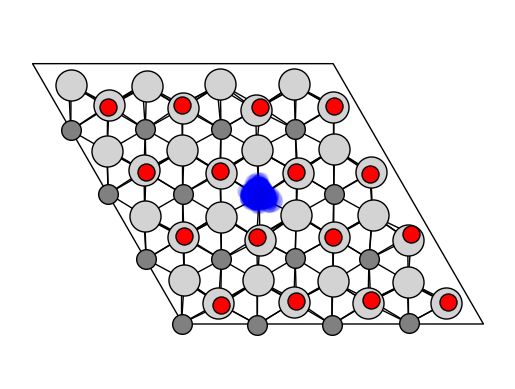

In [78]:
plot_mxene(mg_na_traj[-1])
plt.scatter(na_positions_mg_folded[:, 0], na_positions_mg_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)
plt.savefig("figures/mg_na_path2.png", dpi = 500)

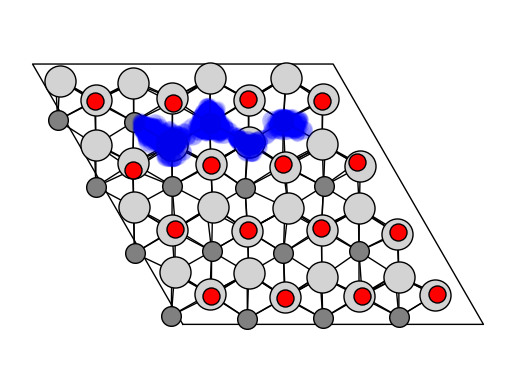

In [79]:
plot_mxene(mgo_na_traj[-1])
plt.scatter(na_positions_mgo_folded[:, 0], na_positions_mgo_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)
plt.savefig("figures/mgo_na_path2.png", dpi = 500)

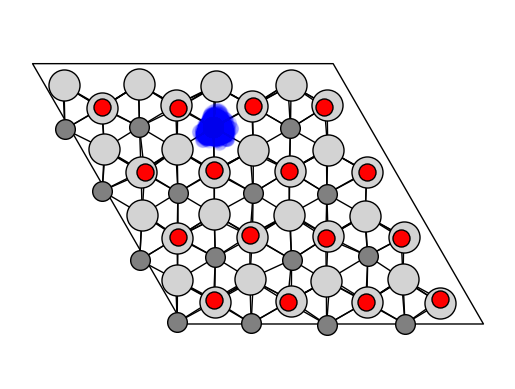

In [80]:
plot_mxene(mgoh_na_traj[-1])
plt.scatter(na_positions_mgoh_folded[:, 0], na_positions_mgoh_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)
plt.savefig("figures/mgoh_na_path2.png", dpi = 500)

### Open circuit voltage

$$OCV \approx - \frac{E_{Na_{x_2}/heterostructure} - E_{Na_{x_1}/heterostructure} - (x_2 - x_1)E_{Na}}{(x_2 - x_1)e} $$
- $E_{Na_{x_2}/heterostructure}$: energy of Na in heterostructure with x_2 Na ions

In [520]:
m_go_relaxed = io.read("structures/m_go_relaxed_omat.xyz")
m_go_na_relaxed = io.read("structures/m_go_na_relaxed_omat.xyz")
m_go_na_many_relaxed = io.read("structures/m_go_na_many_relaxed_omat.xyz")

In [521]:
m_go_relaxed

Atoms(symbols='C66O33Ti32', pbc=[True, True, False], cell=[[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]], tags=..., calculator=SinglePointCalculator(...))

In [633]:
bulk_Na = bulk("Na", "bcc", a=4.23)
Na_supercell = bulk_Na.repeat((10, 10, 10))
Na_supercell.calc = macemp_omat
Na_supercell.get_potential_energy() / len(Na_supercell)

-1.451157757664409

In [ ]:
m_go_relaxed.calc = macemp_omat
m_go_na_relaxed.calc = macemp_omat
m_go_na_many_relaxed.calc = macemp_omat
Na_supercell.calc = macemp_omat

E_hetero = m_go_relaxed.get_potential_energy()
E_x1 = m_go_na_relaxed.get_potential_energy()
E_x2 = m_go_na_many_relaxed.get_potential_energy()
E_bulk = Na_supercell.get_potential_energy() / len(Na_supercell)

# unit of get_potential_energy is eV

# Define x1 and x2 (metal concentrations)
x1 = 0
x2 = 1

# Compute Open Circuit Voltage (OCV)
#V_ocv = - (E_x1 - E_x2 - (x1 - x2) * E_bulk) / ((x1 - x2)*1.6)
V_ocv = - (E_hetero - E_x1 - (x1 - x2) * E_bulk) / ((x1 - x2))


print(f"Open Circuit Voltage (V_ocv): {V_ocv:.3f} V")

Open Circuit Voltage (V_ocv): -1.200 V


In [876]:
m_go_relaxed_omat = io.read("structures/m_go_relaxed_omat.xyz")
m_go_na_relaxed_1 = io.read("structures/m_go_na_relaxed_fixed_omat_1.xyz")
m_go_na_relaxed_2 = io.read("structures/m_go_na_relaxed_fixed_omat_2.xyz")
m_go_na_relaxed_3 = io.read("structures/m_go_na_relaxed_fixed_omat_3.xyz")
m_go_na_relaxed_4 = io.read("structures/m_go_na_relaxed_fixed_omat_4.xyz")
m_go_na_relaxed_5 = io.read("structures/m_go_na_relaxed_fixed_omat_5.xyz")
m_go_na_relaxed_6 = io.read("structures/m_go_na_relaxed_fixed_omat_6.xyz")
m_go_na_relaxed_7 = io.read("structures/m_go_na_relaxed_fixed_omat_7.xyz")
m_go_na_relaxed_8 = io.read("structures/m_go_na_relaxed_fixed_omat_8.xyz")
m_go_na_relaxed_9 = io.read("structures/m_go_na_relaxed_fixed_omat_9.xyz")

m_go_relaxed_omat.calc = macemp_omat
m_go_na_relaxed_1.calc = macemp_omat
m_go_na_relaxed_2.calc = macemp_omat
m_go_na_relaxed_3.calc = macemp_omat
m_go_na_relaxed_4.calc = macemp_omat
m_go_na_relaxed_5.calc = macemp_omat
m_go_na_relaxed_6.calc = macemp_omat
m_go_na_relaxed_7.calc = macemp_omat
m_go_na_relaxed_8.calc = macemp_omat
m_go_na_relaxed_9.calc = macemp_omat

structures_na_list = [m_go_relaxed_omat,
                        m_go_na_relaxed_1, 
                        m_go_na_relaxed_2, 
                        m_go_na_relaxed_3, 
                        m_go_na_relaxed_4, 
                        m_go_na_relaxed_5, 
                        m_go_na_relaxed_6, 
                        m_go_na_relaxed_7, 
                        m_go_na_relaxed_8, 
                        m_go_na_relaxed_9]

In [877]:
m_go_relaxed_omat.get_potential_energy(), m_go_na_relaxed_1.get_potential_energy(), m_go_na_relaxed_2.get_potential_energy(), m_go_na_relaxed_3.get_potential_energy(), m_go_na_relaxed_4.get_potential_energy(), m_go_na_relaxed_5.get_potential_energy(), m_go_na_relaxed_6.get_potential_energy(), m_go_na_relaxed_7.get_potential_energy(), m_go_na_relaxed_8.get_potential_energy(), m_go_na_relaxed_9.get_potential_energy()

(-1206.1795555224116,
 -1209.4400367507453,
 -1212.5093263675412,
 -1215.1072943077345,
 -1218.289474452423,
 -1220.740915468811,
 -1223.839547610509,
 -1226.09314971958,
 -1228.1895498665099,
 -1230.4050282760093)

In [889]:
bulk_Na = bulk("Na", "bcc", a=4.23)
Na_supercell = bulk_Na.repeat((8, 8, 8))
Na_supercell.calc = macemp_omat
E_bulk = Na_supercell.get_potential_energy() / len(Na_supercell)
E_hetero = m_go_relaxed_omat.get_potential_energy()

e = 1.602176634e-19

Voc_list = []
for i in range(len(structures_na_list)-1):

    #E_x1 = structures_na_list[i].get_potential_energy()
    E_x1 = E_hetero
    E_x2 = structures_na_list[i+1].get_potential_energy()
    x1 = 0
    x2 = (i + 1)
    
    
    V_ocv = (E_x1 - E_x2 + (x2 - x1) * E_bulk) / ((x2 - x1))
    Voc_list.append(V_ocv)

In [883]:
Voc_list

[1.8093234706692616,
 1.7137276649003812,
 1.5247551707765357,
 1.5763219748384418,
 1.4611142316154488,
 1.4921742570184868,
 1.3936414133596335,
 1.3000915353478664,
 1.2405614371797666]

In [834]:
Voc_list

[1.9203099904369825,
 2.3710503518392505,
 2.151565670172096,
 2.3228170343167056,
 2.0244809987046954,
 1.4712211951063014,
 1.4883208993115946,
 1.4252708358086525,
 1.1418412380870737]

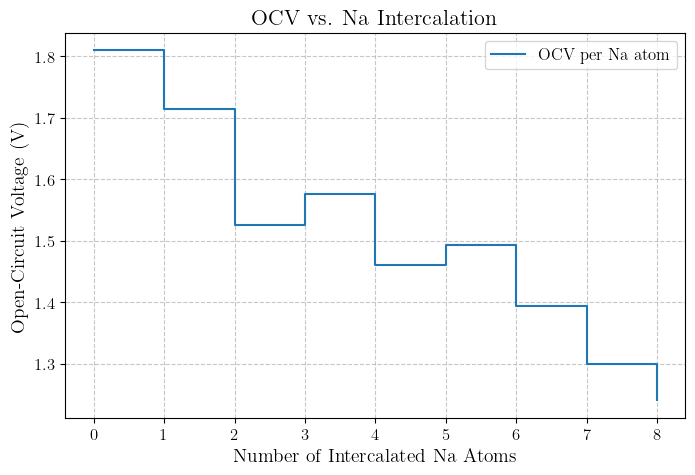

In [ ]:
x_values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.figure(figsize=(8, 5))
plt.step(x_values[:-1], Voc_list, where='post', label="OCV per Na atom")
plt.xlabel("Number of Intercalated Na Atoms")
plt.ylabel("Open-Circuit Voltage (V)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Creating intercalcation structures with 1-9 Na ions

In [545]:
m_go_relaxed_omat = io.read("structures/m_go_relaxed_omat.xyz")

In [566]:
import numpy as np
from ase import Atoms

def add_sodium_many(heterostructure, n_Na=9):
    """
    Adds up to `n_Na` sodium ions to the heterostructure, filling the middle row first, 
    then alternating between the top and bottom rows.

    - Middle row (up to 3 Na)
    - Then alternates between top and bottom rows (max 3 each)
    """

    heterostructure = heterostructure.copy()
    
    # Get z-coordinates of graphene (C atoms) and MXene (O atoms)
    graphene_C_atoms = [atom.position[2] for atom in heterostructure if atom.tag == 10]
    mxene_O_atoms = [atom.position[2] for atom in heterostructure if atom.tag == 3]
    
    z_mxene = np.mean(mxene_O_atoms)
    z_graphene = np.mean(graphene_C_atoms)

    # Place Na halfway between MXene and graphene
    na_z = z_mxene + 0.5 * (z_graphene - z_mxene)

    # Get unit cell boundaries
    positions = heterostructure.get_positions()
    xmin, ymin = np.min(positions[:, :2], axis=0)
    xmax, ymax = np.max(positions[:, :2], axis=0)

    # Define y-positions for the three rows
    y_positions = np.linspace(ymin+0.5, ymax-0.5, 3)  # Three distinct rows

    # Define x-positions for each row (evenly spaced)
    x_positions_top = np.linspace(xmin, xmax, 3, endpoint=False)  # 3 in top row
    x_positions_bottom = np.linspace(xmin+5, xmax+5, 3, endpoint=False)  # 3 in bottom row
    
    # Middle row: Offset x-coordinates to be in between the top and bottom row Na positions
    x_spacing = (x_positions_top[1] - x_positions_top[0]) / 2  # Half the x-spacing of top row
    #x_positions_middle = x_positions_top[:-1] + x_spacing  # Shifted to the gaps
    x_positions_middle = np.linspace(xmin + x_spacing, xmax - x_spacing, 3)
    
    # Construct Na positions based on priority order
    placement_order = []
    
    # Fill the middle row first (max 3 Na)
    for x in x_positions_middle:
        placement_order.append((x, y_positions[1]))  # Middle row (y_positions[1])
    
    # Alternate between top and bottom rows
    for i in range(3):
        placement_order.append((x_positions_top[i], y_positions[2]))   # Top row
        placement_order.append((x_positions_bottom[i], y_positions[0])) # Bottom row

    # Trim to match n_Na
    placement_order = placement_order[:n_Na]

    # Create final Na positions
    na_positions = [[x, y, na_z] for x, y in placement_order]

    # Create Na atoms and add them to the heterostructure
    na_atoms = Atoms("Na" * n_Na, positions=na_positions)
    heterostructure += na_atoms  # Append Na to the structure

    return heterostructure


In [857]:
m_go_na_1 = add_sodium_many(m_go_relaxed_omat, n_Na=1)
m_go_na_2 = add_sodium_many(m_go_relaxed_omat, n_Na=2)
m_go_na_3 = add_sodium_many(m_go_relaxed_omat, n_Na=3)
m_go_na_4 = add_sodium_many(m_go_relaxed_omat, n_Na=4)
m_go_na_5 = add_sodium_many(m_go_relaxed_omat, n_Na=5)
m_go_na_6 = add_sodium_many(m_go_relaxed_omat, n_Na=6)
m_go_na_7 = add_sodium_many(m_go_relaxed_omat, n_Na=7)
m_go_na_8 = add_sodium_many(m_go_relaxed_omat, n_Na=8)
m_go_na_9 = add_sodium_many(m_go_relaxed_omat, n_Na=9)

In [858]:
from ase.constraints import FixAtoms

In [860]:
m_go_na_relaxed_1 = m_go_na_1.copy()
m_go_na_relaxed_1.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_1 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_1.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_1)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:47:45    -1208.600977        1.528616
BFGS:    1 13:47:48    -1208.630655        1.194885
BFGS:    2 13:47:52    -1208.679708        0.582507
BFGS:    3 13:47:56    -1208.684727        0.603289
BFGS:    4 13:47:59    -1208.785106        0.923950
BFGS:    5 13:48:03    -1208.898862        0.922090
BFGS:    6 13:48:08    -1209.019841        0.750980
BFGS:    7 13:48:12    -1209.144378        0.627617
BFGS:    8 13:48:16    -1209.252083        0.473989
BFGS:    9 13:48:20    -1209.298578        0.342586
BFGS:   10 13:48:24    -1209.299506        0.324956
BFGS:   11 13:48:28    -1209.302061        0.299719
BFGS:   12 13:48:32    -1209.315385        0.255966
BFGS:   13 13:48:36    -1209.342677        0.368043
BFGS:   14 13:48:42    -1209.369651        0.474134
BFGS:   15 13:48:46    -1209.392520        0.533824
BFGS:   16 13:48:50    -1209.413038        0.561457
BFGS:   17 13:48:54    -1209.414181        0.597900
BFGS:   18 13:

True

In [861]:
io.write("structures/m_go_na_relaxed_fixed_omat_1.xyz", m_go_na_relaxed_1)

In [862]:
m_go_na_relaxed_2 = m_go_na_2.copy()
m_go_na_relaxed_2.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_2 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_2.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_2)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:49:43    -1210.951452        2.680064
BFGS:    1 13:49:46    -1211.074288        2.211440
BFGS:    2 13:49:51    -1211.343539        0.763035
BFGS:    3 13:49:54    -1211.365880        0.778992
BFGS:    4 13:49:58    -1211.449366        1.165793
BFGS:    5 13:50:01    -1211.572927        1.557741
BFGS:    6 13:50:05    -1211.674642        1.657696
BFGS:    7 13:50:09    -1211.733851        1.705821
BFGS:    8 13:50:13    -1211.804103        1.356655
BFGS:    9 13:50:18    -1212.003696        0.952784
BFGS:   10 13:50:23    -1212.084506        0.855421
BFGS:   11 13:50:28    -1212.149430        0.755620
BFGS:   12 13:50:32    -1212.189533        0.502088
BFGS:   13 13:50:35    -1212.199563        0.420970
BFGS:   14 13:50:40    -1212.219604        0.417872
BFGS:   15 13:50:44    -1212.257029        0.941351
BFGS:   16 13:50:48    -1212.277634        1.004342
BFGS:   17 13:50:52    -1212.337362        0.842409
BFGS:   18 13:

True

In [863]:
io.write("structures/m_go_na_relaxed_fixed_omat_2.xyz", m_go_na_relaxed_2)

In [864]:
m_go_na_relaxed_3 = m_go_na_3.copy()
m_go_na_relaxed_3.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_3 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_3.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_3)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:52:22    -1204.595707        9.486667
BFGS:    1 13:52:27    -1207.879813       13.828317
BFGS:    2 13:52:32    -1211.528265        4.917885
BFGS:    3 13:52:36    -1212.370683        2.739369
BFGS:    4 13:52:41    -1213.031092        1.647591
BFGS:    5 13:52:45    -1213.326926        1.193620
BFGS:    6 13:52:48    -1213.442082        1.673340
BFGS:    7 13:52:52    -1213.651522        2.086004
BFGS:    8 13:52:56    -1213.869128        2.021106
BFGS:    9 13:53:00    -1214.072228        1.732728
BFGS:   10 13:53:04    -1214.236446        1.304783
BFGS:   11 13:53:09    -1214.336063        0.832833
BFGS:   12 13:53:15    -1214.374289        0.714798
BFGS:   13 13:53:18    -1214.447113        0.835025
BFGS:   14 13:53:23    -1214.515152        1.134362
BFGS:   15 13:53:27    -1214.544374        1.123597
BFGS:   16 13:53:32    -1214.620536        0.909071
BFGS:   17 13:53:36    -1214.714425        0.875729
BFGS:   18 13:

True

In [865]:
io.write("structures/m_go_na_relaxed_fixed_omat_3.xyz", m_go_na_relaxed_3)

In [851]:
view(m_go_na_relaxed_4, viewer="x3d")

In [849]:
m_go_na_relaxed_4 = m_go_na_4.copy()
m_go_na_relaxed_4.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_4 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_4.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_4)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:30:18    -1206.922173        9.632556
BFGS:    1 13:30:22    -1210.329189       13.778374
BFGS:    2 13:30:25    -1213.955499        4.831516
BFGS:    3 13:30:30    -1214.802026        2.711176
BFGS:    4 13:30:34    -1215.488851        1.633236
BFGS:    5 13:30:40    -1215.784691        1.193112
BFGS:    6 13:30:45    -1215.910888        1.681806
BFGS:    7 13:30:49    -1216.139890        2.123971
BFGS:    8 13:30:53    -1216.378168        2.098210
BFGS:    9 13:30:57    -1216.602794        1.840340
BFGS:   10 13:31:01    -1216.789387        1.426557
BFGS:   11 13:31:05    -1216.911967        0.891122
BFGS:   12 13:31:09    -1216.962455        0.768221
BFGS:   13 13:31:14    -1217.020141        0.659439
BFGS:   14 13:31:20    -1217.147939        1.203280
BFGS:   15 13:31:25    -1217.185548        1.240598
BFGS:   16 13:31:28    -1217.320821        1.088127
BFGS:   17 13:31:32    -1217.432675        1.089795
BFGS:   18 13:

True

In [852]:
io.write("structures/m_go_na_relaxed_fixed_omat_4.xyz", m_go_na_relaxed_4)

In [866]:
m_go_na_relaxed_5 = m_go_na_5.copy()
m_go_na_relaxed_5.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_5 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_5.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_5)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:55:29    -1206.138269        9.745538
BFGS:    1 13:55:32    -1211.019140       13.749262
BFGS:    2 13:55:34    -1215.731726        4.824302
BFGS:    3 13:55:37    -1217.130390        2.460214
BFGS:    4 13:55:40    -1218.205718        1.462718
BFGS:    5 13:55:42    -1218.648139        1.726641
BFGS:    6 13:55:45    -1218.841499        2.168296
BFGS:    7 13:55:47    -1219.147942        1.946635
BFGS:    8 13:55:49    -1219.414708        2.328014
BFGS:    9 13:55:52    -1219.629369        1.998289
BFGS:   10 13:55:54    -1219.789987        1.134624
BFGS:   11 13:55:57    -1219.895598        1.255835
BFGS:   12 13:55:59    -1219.980400        1.270950
BFGS:   13 13:56:02    -1220.093732        0.966696
BFGS:   14 13:56:04    -1220.179549        0.967986
BFGS:   15 13:56:06    -1220.246649        0.891644
BFGS:   16 13:56:10    -1220.310048        0.916611
BFGS:   17 13:56:12    -1220.395963        1.242248
BFGS:   18 13:

True

In [867]:
io.write("structures/m_go_na_relaxed_fixed_omat_5.xyz", m_go_na_relaxed_5)

In [868]:
m_go_na_relaxed_6 = m_go_na_6.copy()
m_go_na_relaxed_6.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_6 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_6.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_6)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 13:59:53    -1208.669100        9.823378
BFGS:    1 13:59:55    -1213.630003       13.725886
BFGS:    2 13:59:57    -1218.344593        4.794318
BFGS:    3 14:00:01    -1219.772390        2.435182
BFGS:    4 14:00:05    -1220.887808        1.431927
BFGS:    5 14:00:09    -1221.336906        1.740794
BFGS:    6 14:00:13    -1221.543352        2.182253
BFGS:    7 14:00:17    -1221.874878        1.965098
BFGS:    8 14:00:21    -1222.164190        2.396578
BFGS:    9 14:00:25    -1222.398996        2.112397
BFGS:   10 14:00:29    -1222.569983        1.219681
BFGS:   11 14:00:33    -1222.688742        1.250961
BFGS:   12 14:00:37    -1222.780493        1.265288
BFGS:   13 14:00:41    -1222.902248        0.964493
BFGS:   14 14:00:45    -1222.991826        0.987172
BFGS:   15 14:00:49    -1223.058390        0.910312
BFGS:   16 14:00:53    -1223.117943        0.814623
BFGS:   17 14:00:56    -1223.195766        1.089406
BFGS:   18 14:

True

In [869]:
io.write("structures/m_go_na_relaxed_fixed_omat_6.xyz", m_go_na_relaxed_6)

In [870]:
m_go_na_relaxed_7 = m_go_na_7.copy()
m_go_na_relaxed_7.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_7 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_7.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_7)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 14:08:18    -1207.847294        9.871407
BFGS:    1 14:08:22    -1214.246557       13.697240
BFGS:    2 14:08:26    -1219.383873        4.742797
BFGS:    3 14:08:30    -1221.332097        2.305658
BFGS:    4 14:08:33    -1222.946063        1.542466
BFGS:    5 14:08:36    -1223.619312        2.058833
BFGS:    6 14:08:41    -1223.894661        2.449499
BFGS:    7 14:08:44    -1224.285969        1.971444
BFGS:    8 14:08:48    -1224.636942        2.258897
BFGS:    9 14:08:51    -1224.964334        2.117259
BFGS:   10 14:08:55    -1225.200782        1.542282
BFGS:   11 14:08:59    -1225.373065        1.593167
BFGS:   12 14:09:03    -1225.467952        1.376836
BFGS:   13 14:09:08    -1225.562899        0.774300
BFGS:   14 14:09:13    -1225.614150        0.588900
BFGS:   15 14:09:19    -1225.644238        0.603554
BFGS:   16 14:09:23    -1225.674906        0.819385
BFGS:   17 14:09:27    -1225.728095        0.913223
BFGS:   18 14:

True

In [871]:
io.write("structures/m_go_na_relaxed_fixed_omat_7.xyz", m_go_na_relaxed_7)

In [872]:
m_go_na_relaxed_8 = m_go_na_8.copy()
m_go_na_relaxed_8.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_8 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_8.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_8)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 14:13:01    -1192.785738       26.073318
BFGS:    1 14:13:05    -1206.089721       16.618990
BFGS:    2 14:13:08    -1216.056573        8.253340
BFGS:    3 14:13:12    -1220.610428        3.812768
BFGS:    4 14:13:15    -1223.091095        2.457305
BFGS:    5 14:13:19    -1224.753794        1.600660
BFGS:    6 14:13:23    -1225.421426        2.435787
BFGS:    7 14:13:27    -1225.780521        2.347512
BFGS:    8 14:13:30    -1226.213028        1.972415
BFGS:    9 14:13:34    -1226.533180        1.671266
BFGS:   10 14:13:38    -1226.806628        1.346286
BFGS:   11 14:13:42    -1226.984542        1.646247
BFGS:   12 14:13:45    -1227.113031        1.529921
BFGS:   13 14:13:49    -1227.269676        1.022035
BFGS:   14 14:13:53    -1227.394672        0.949643
BFGS:   15 14:13:56    -1227.475563        0.826805
BFGS:   16 14:14:00    -1227.527537        1.083172
BFGS:   17 14:14:04    -1227.593566        1.053789
BFGS:   18 14:

True

In [873]:
io.write("structures/m_go_na_relaxed_fixed_omat_8.xyz", m_go_na_relaxed_8)

In [874]:
m_go_na_relaxed_9 = m_go_na_9.copy()
m_go_na_relaxed_9.calc = macemp_omat

fix_indices = [atom.index for atom in m_go_na_relaxed_9 if atom.symbol != "Na"]
constraints = [FixAtoms(indices=fix_indices)]
m_go_na_relaxed_9.set_constraint(constraints)

optimiser = BFGS(m_go_na_relaxed_9)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 14:19:43    -1181.308054       37.551427
BFGS:    1 14:19:46    -1197.862962       17.352499
BFGS:    2 14:19:51    -1212.934494        8.442972
BFGS:    3 14:19:54    -1219.006398        5.070372
BFGS:    4 14:19:58    -1222.700678        3.325438
BFGS:    5 14:20:02    -1225.116514        2.282615
BFGS:    6 14:20:06    -1226.528299        2.301539
BFGS:    7 14:20:10    -1227.393962        2.756203
BFGS:    8 14:20:13    -1227.920756        2.176994
BFGS:    9 14:20:17    -1228.247595        2.002372
BFGS:   10 14:20:22    -1228.673784        1.703666
BFGS:   11 14:20:26    -1228.913760        1.623028
BFGS:   12 14:20:33    -1229.066963        1.702764
BFGS:   13 14:20:38    -1229.236159        1.378566
BFGS:   14 14:20:43    -1229.392563        1.040298
BFGS:   15 14:20:47    -1229.507584        0.964640
BFGS:   16 14:20:51    -1229.577080        0.897024
BFGS:   17 14:20:55    -1229.630868        1.025764
BFGS:   18 14:

True

In [875]:
io.write("structures/m_go_na_relaxed_fixed_omat_9.xyz", m_go_na_relaxed_9)